In [3]:
# Objective is to link up the devon dataset with a PV system in the area
# start off with predicting PV based on image, not including time series aspect

# Potentially useful tutorial here https://medium.com/analytics-vidhya/fastai-image-regression-age-prediction-based-on-image-68294d34f2ed
# Illinois converting data to numpy https://github.com/jmather625/climatehack/blob/main/data/download_data.ipynb

### 1. Importing data

In [4]:
import numpy as np
import datetime
import pandas as pd
import xarray as xr
import tqdm

In [5]:
# X: dataset            # cropped satellite image
# Y: devon_pv_df        # pv_yield

#### PV yield

In [6]:
pv_power = xr.open_dataset("data/uk_pv/pv.netcdf", engine="h5netcdf")
# PV yield is every 5 minutes, from 2018-01-01 to 2021-10-27, from 6am to 7pm

devon_pv_df = pv_power['6848'].to_dataframe()

# cropping for 2020-01-01 to 2021-11-07

devon_pv_df = devon_pv_df[devon_pv_df.index < '2020-12-30']
devon_pv_df = devon_pv_df[devon_pv_df.index > '2020-01-01']

In [7]:
#devon_pv_df.drop(columns=1)
pv_times_list = devon_pv_df.index.tolist()
print('Number of PV readings :', len(pv_times_list))

Number of PV readings : 104532


#### Sat images

In [8]:
# I then cropped the satellite dataset using time-crop.ipnyb to get only PV images between 06:00 and 20:00

# sat_times: a numpy array of timestamps for PV data between 06:00 and 20:00
# pv_slices: a numpy array of PV data for the associated timestamps above

In [9]:
cropped_sat_times = np.load('data/sat_times_2020.npy')
cropped_sat_times_list = cropped_sat_times.tolist()
len(cropped_sat_times) # we have 50K sat_times

55787

In [10]:
# convert back to datetime format (since changed into int when converted into numpy)
cropped_sat_times_list[0]

for i in range(len(cropped_sat_times_list)):
    cropped_sat_times_list[i] = np.datetime64(cropped_sat_times_list[i],"ns")

In [11]:
# 1GB file
sat_data = np.load('data/sat_slices_2020.npy')

In [12]:
print(sat_data.shape)

(55787, 100, 100)


In [13]:
sat_data[1]

array([[13, 12, 12, ..., 12, 12, 12],
       [13, 12, 12, ..., 12, 13, 13],
       [12, 13, 12, ..., 15, 12, 12],
       ...,
       [12, 12, 13, ..., 12, 12, 12],
       [12, 12, 13, ..., 13, 13, 12],
       [12, 12, 12, ..., 12, 12, 13]], dtype=int16)

In [14]:
print(cropped_sat_times_list[0])

2020-01-01T06:00:00.000000000


#### Do we have PV readings for all sat images?

In [15]:
# So we have 54K satellite images
# We have 100K PV data readings

# There will be lots of PV data readings to drop, because they'll be outside the range
# We should loop through PV data readings, and if there's a satellite image, add it to an array

In [16]:
len(pv_times_list)

104532

In [18]:
# Now let's see if we have PV readings for all of these sat images

pv_readings = []
sat_images = []
i = 0

for time in tqdm.tqdm(pv_times_list[:10000]):
    if time in cropped_sat_times_list[:10000]:
        # Add the PV reading
        pv_readings.append(devon_pv_df[devon_pv_df.index == time])
        # Add the satellite image 
        sat_images.append(sat_data[i])
        #sat_images[i] = sat_data[i]
        i +=1 
    else:
        i +=1 


100%|██████████| 10000/10000 [05:07<00:00, 32.50it/s]


In [19]:
# Just took the first 10,000 from each list, it was taking a long time otherwise

len(pv_readings)

1163

In [20]:
len(sat_images)

1163

In [21]:
# The inputs are both lists of arrays, should I convert them to arrays?

pv_readings = np.asarray(pv_readings)
sat_images = np.asarray(sat_images)

# Scale images down by dividing by 255

sat_images_scaled = sat_images / 255

# Should I scale the PV yield?
 


In [22]:
# Saving this stuff, it took >20 mins to run 

np.save('data/sat_images_2020_devon_timecropped_scaled', sat_images_scaled)
np.save('data/pv_yield_2020_devon_timecropped', pv_readings)

#### Training a model 

In [23]:
from sklearn.model_selection import train_test_split

X = sat_images_scaled
y = pv_readings

train_images, test_images, train_labels, test_labels = train_test_split(X, y, random_state=42)

In [ ]:
# Think I need to resize the images

In [24]:
train_images[0]

array([[0.78039216, 0.79215686, 0.79215686, ..., 0.68627451, 0.68627451,
        0.6745098 ],
       [0.77254902, 0.78431373, 0.80392157, ..., 0.67058824, 0.62352941,
        0.56862745],
       [0.76862745, 0.80392157, 0.81960784, ..., 0.60392157, 0.54117647,
        0.47843137],
       ...,
       [0.47058824, 0.43529412, 0.4       , ..., 0.24313725, 0.24313725,
        0.2627451 ],
       [0.4       , 0.38823529, 0.38823529, ..., 0.2627451 , 0.29019608,
        0.33333333],
       [0.39607843, 0.38823529, 0.41176471, ..., 0.32156863, 0.36862745,
        0.38823529]])

In [25]:
from PIL import Image as im

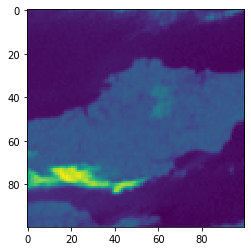

In [32]:
from matplotlib import pyplot as plt
plt.imshow(train_images[5], interpolation='nearest')
plt.show()

In [35]:
train_labels[1][0][0]

0.0

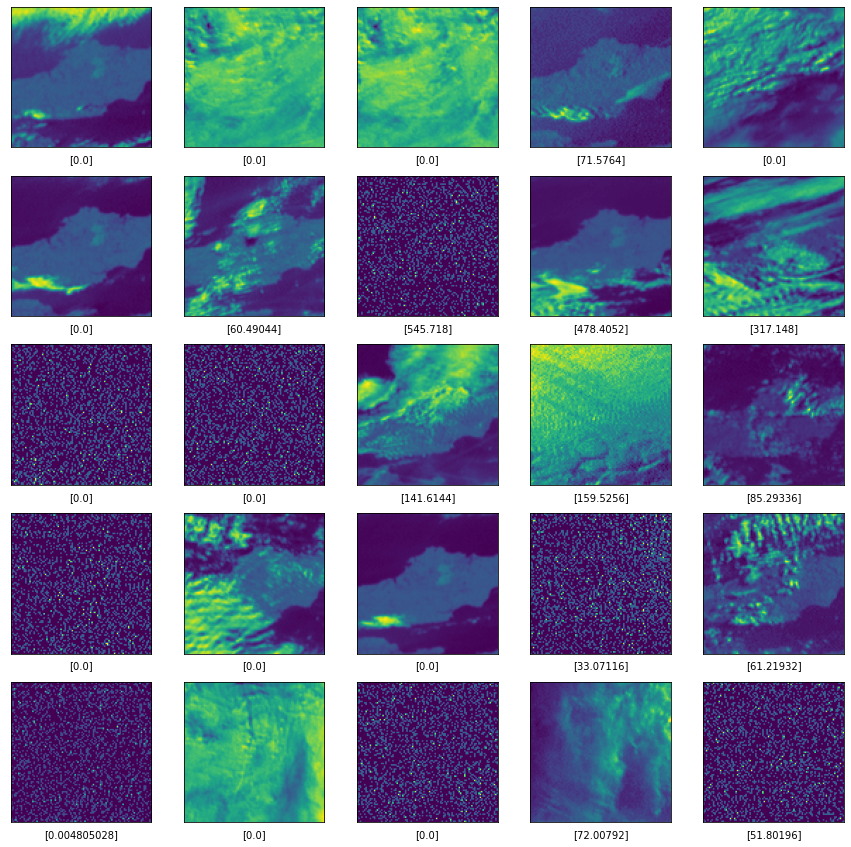

In [44]:
# Yeah I don't think these line up

plt.figure(figsize=(15,15))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel([train_labels[i][0][0]])
plt.show()

In [ ]:
# tf tutorial https://www.tensorflow.org/tutorials/images/cnn

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1))) # changed input size to 100x100, from input_shape=(32,32,3)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Linear(1)) # change from 10 to 1, as I think we only predict one thing, also changed from Dense to Linear

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Changed from 10 epochs down to 5

history = model.fit(train_images, train_labels, epochs=5, 
                    validation_data=(test_images, test_labels))

                    

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)